In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
### constants
LABELS = ['Normal', 'Fraud']
RANDOM_SEED = 105
UPDATE_SIZE = 0.3
TEST_SIZE = 0.2
DATASET_PATH = Path('../creditcard.csv')

In [3]:
### data reading
df = pd.read_csv(DATASET_PATH)
#df.describe()

In [4]:
### data preparing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### преобразуем данные, убираем колонку "время", т.к. она ни на что не влияет
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

### отделяем X от Y
Y = data['Class'].values
X = data.drop(['Class'], axis=1).values

#stratify +

### делим данные
X_train, X_tmp, Y_train, Y_tmp = train_test_split(
    X, Y, test_size=0.3, random_state=RANDOM_SEED, shuffle=True)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tmp, Y_tmp, test_size=UPDATE_SIZE, random_state=RANDOM_SEED, shuffle=True)

In [5]:
### количество мошенничеств в тестовых данных
sum(Y_test)

48

In [6]:
### Creating model
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


input_dim = X_train.shape[1]
encoding_dim = 14

Using TensorFlow backend.


In [7]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [8]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5',
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 59810 samples, validate on 25633 samples
Epoch 1/100
59810/59810 [==============================] - 2s 39us/step - loss: 0.9005 - accuracy: 0.5113 - val_loss: 0.8695 - val_accuracy: 0.5902
Epoch 2/100
59810/59810 [==============================] - 2s 35us/step - loss: 0.8118 - accuracy: 0.6050 - val_loss: 0.8305 - val_accuracy: 0.6151
Epoch 3/100
59810/59810 [==============================] - 2s 35us/step - loss: 0.7898 - accuracy: 0.6148 - val_loss: 0.8148 - val_accuracy: 0.6141
Epoch 4/100
59810/59810 [==============================] - 2s 34us/step - loss: 0.7754 - accuracy: 0.6243 - val_loss: 0.8025 - val_accuracy: 0.6338
Epoch 5/100
59810/59810 [==============================] - 2s 39us/step - loss: 0.7630 - accuracy: 0.6403 - val_loss: 0.7908 - val_accuracy: 0.6422
Epoch 6/100
59810/59810 [==============================] - 2s 37us/step - loss: 0.7564 - accuracy: 0.6504 - val_loss: 0.7830 - val_accuracy: 0.6593
Epoch 7/100
59810/59810 [==============================] - 2s 

Epoch 56/100
59810/59810 [==============================] - 3s 44us/step - loss: 0.7310 - accuracy: 0.6767 - val_loss: 0.7541 - val_accuracy: 0.6810
Epoch 57/100
59810/59810 [==============================] - 2s 37us/step - loss: 0.7301 - accuracy: 0.6786 - val_loss: 0.7534 - val_accuracy: 0.6836
Epoch 58/100
59810/59810 [==============================] - 2s 37us/step - loss: 0.7298 - accuracy: 0.6790 - val_loss: 0.7553 - val_accuracy: 0.6857
Epoch 59/100
59810/59810 [==============================] - 2s 38us/step - loss: 0.7298 - accuracy: 0.6808 - val_loss: 0.7537 - val_accuracy: 0.6835
Epoch 60/100
59810/59810 [==============================] - 2s 36us/step - loss: 0.7292 - accuracy: 0.6793 - val_loss: 0.7527 - val_accuracy: 0.6827
Epoch 61/100
59810/59810 [==============================] - 2s 37us/step - loss: 0.7300 - accuracy: 0.6809 - val_loss: 0.7537 - val_accuracy: 0.6826
Epoch 62/100
59810/59810 [==============================] - 2s 37us/step - loss: 0.7294 - accuracy: 0.6813

In [ ]:
model = load_model('model.h5')

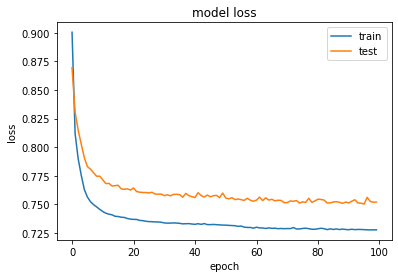

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
predictions = autoencoder.predict(X_test)

In [14]:
import numpy as np


mse = np.mean(np.power(X_test - predictions, 2), axis=1)

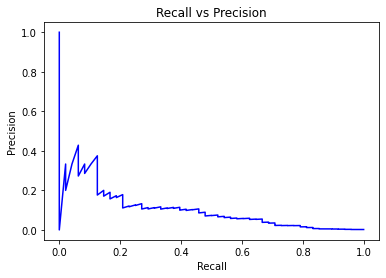

In [16]:
from sklearn.metrics import precision_recall_curve


precision, recall, th = precision_recall_curve(Y_test, mse)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [44]:
TP, FP, TN, FN = 0, 0, 0, 0

for prediction, true_class in zip(predictions, Y_test):
    TP += int(true_class and prediction)
    FN += int(true_class and not prediction)
    FP += int(not true_class and prediction)
    TN += int(not true_class and not prediction)

TypeError: only size-1 arrays can be converted to Python scalars

In [11]:
print('TP:', TP)  # мошенничество, определено правильно
print('FP:', FP)  # нормальная транзакция, определена неправильно
print('TN:', TN)  # нормальная транзакция, определена правильно
print('FN:', FN)  # мошенничество, определено неправильно

TP: 71
FP: 6
TN: 56867
FN: 18


In [13]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(precision)
print(recall)

0.922077922077922
0.797752808988764


In [34]:
tpr = TP / (TP + FN)  # True positive rate
fpr = FP / (FP + TN)  # False positive rate

print(tpr)
print(fpr)

0.797752808988764
0.00010549821532185747


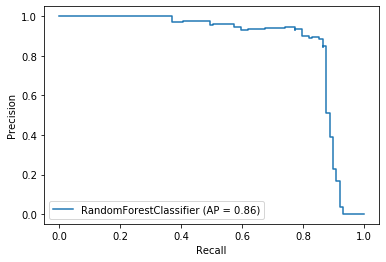

In [35]:
### Precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(model, X_test, Y_test)

In [ ]:
plt.savefig('fname.svg', dpi=300, facecolor='w', edgecolor='red',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1)